# Setup

Use the steady state frames, used in the paper describing the methods. Also uses roughly the same style in the plots.

In [1]:
## Plot in separated windows
# %matplotlib qt

In [2]:
steady_states = {
    "uo-050-180-180": [211, 800],
    "uo-060-180-180": [243, 771],
    "uo-070-180-180": [203, 1113],
    "uo-100-180-180": [200, 790],
    "uo-145-180-180": [300, 1097],
    "uo-180-180-070": [500, 1399],
    "uo-180-180-095": [400, 1350],
    "uo-180-180-120": [300, 1099],
    "uo-180-180-180": [400, 1284],
}



## Load trajectories

In [3]:
import pathlib
from pedpy.column_identifier import *
from pedpy import TrajectoryData, TrajectoryUnit, load_trajectory

folder = pathlib.Path("demo-data/uni-directional")
trajectories = {}
trajectories_in_steady_state = {}
for file in folder.glob("uo*.txt"):
    trajectory = load_trajectory(
        trajectory_file=file,
        default_frame_rate=16.0,
        default_unit=TrajectoryUnit.CENTIMETER,
    )
    trajectory_in_steady_state = TrajectoryData(
        data=trajectory.data[
            trajectory.data.frame.between(
                steady_states[file.stem][0], steady_states[file.stem][1]
            )
        ],
        frame_rate=trajectory.frame_rate,
    )

    trajectories[file.stem] = trajectory
    trajectories_in_steady_state[file.stem] = trajectory_in_steady_state

/Users/thochat/Desktop/Git-projects/PedPy-dev-fork/PedPy/pedpy/methods/temporal_analysis.py:28: SyntaxWarning: invalid escape sequence '\{'
  """Computes the Short-Time Fourier Transform (STFT) of a signal.


## Define geometry

In [4]:
from shapely import Polygon

from pedpy import WalkableArea

walkable_area = WalkableArea(
    Polygon(
        [
            (2.8, -6.5),
            (2.8, -4),
            (1.8, -4),
            (1.8, 4),
            (2.8, 4),
            (2.8, 8),
            (-1, 8),
            (-1, 4),
            (0, 4),
            (0, -4),
            (-1, -4),
            (-1, -6.5),
        ]
    )
)

## Define measurement areas

In [5]:
from pedpy import MeasurementArea, MeasurementLine

measurement_area = MeasurementArea([(0, -2.5), (0, 2), (1.8, 2), (1.8, -2.5)])

## Plot trajectories, geometry, and measurement areas/lines

In [6]:
# import matplotlib.pyplot as plt

# from pedpy import plot_measurement_setup

# fig, axs = plt.subplots(3, int(len(trajectories) / 3), figsize=(10, 30))

# for (name, trajectory), ax in zip(
#     trajectories.items(), axs.ravel(), strict=False
# ):
#     ax.set_title(name)

#     ax = plot_measurement_setup(
#         traj=trajectory,
#         walkable_area=walkable_area,
#         measurement_areas=[measurement_area],
#         axes=ax,
#         traj_width=0.2,
#         traj_start_marker=".",
#         traj_end_marker="x",
#         ma_color="g",
#         ma_line_color="g",
#         ma_alpha=0.2,
#         ml_color="b",
#     )
#     ax.set_aspect("equal")

# fig.tight_layout()
# plt.show()

# Short-Time Fourier Transform (STFT)

In [7]:
TrajectoryData_FT=trajectories["uo-180-180-070"]

# File names
#     "uo-050-180-180" 
#     "uo-060-180-180" 
#     "uo-070-180-180" 
#     "uo-100-180-180" 
#     "uo-145-180-180" 
#     "uo-180-180-070"
#     "uo-180-180-095"
#     "uo-180-180-120"
#     "uo-180-180-180"



## 1) Compute the STFT for the sway of one participant: Computation on raw trajectory data

In [8]:
# # Mockup data for testing
# import pandas as pd
# import numpy as np
# from shapely.geometry import Point

# # Define the number of frames
# num_frames = 400

# # Create the DataFrame
# data = []
# for id_val in [1, 2]:  # Two unique IDs
#     for frame in range(num_frames+500*id_val):
#         x =  np.sin(0.2*np.pi*frame / TrajectoryData_FT.frame_rate)+np.sin(4*np.pi*frame / TrajectoryData_FT.frame_rate)+4  # Compute x as cos(frame/16) +4
#         y = 2*frame / TrajectoryData_FT.frame_rate  # Compute y as 1.5*(frame/16)
#         point = Point(x, y)  # Create Shapely Point
        
#         data.append([id_val, frame, x, y, point])

# # Convert to DataFrame
# mock_data = pd.DataFrame(data, columns=["id", "frame", "x", "y", "point"])


# TrajectoryData_FT= TrajectoryData(
#         data=mock_data,
#         frame_rate=TrajectoryData_FT.frame_rate,
#     )

In [9]:
from pedpy import compute_STFT

# Group the data by 'id' and apply the STFT function
stft_results = (
    TrajectoryData_FT.data.groupby("id")[X_COL]
    .apply(lambda x: compute_STFT(x, 
                                  TrajectoryData_FT.frame_rate, 
                                  segments_length=5*TrajectoryData_FT.frame_rate, 
                                  overlap_length=2*TrajectoryData_FT.frame_rate,
                                  zeros_padded=10*TrajectoryData_FT.frame_rate))
)

# Reset index to  makes "id" a column instead of an index.
stft_results = stft_results.reset_index()

### Normalisation of the results

In [10]:
import numpy as np
# Find the maximum Time value and its associated id
max_time_row = stft_results.loc[stft_results["Time"].idxmax()]
max_time = max_time_row["Time"]
max_time_id = max_time_row["id"]


# print(f"Max Time: {max_time}, Associated ID: {max_time_id}")

# Determine time resolution of the series for the ID with max Time
max_time_series = stft_results[stft_results["id"] == max_time_id]
time_resolution = np.diff(np.sort(max_time_series["Time"].unique())).min()

# print(f"Time resolution for ID {max_time_id}: {time_resolution}")

In [11]:
# Resample all time series and interpolate missing values
import pandas as pd
from scipy.interpolate import interp1d

# Create a new uniform time grid for resampling
new_time_grid = np.arange(0, max_time + time_resolution, time_resolution)

# loop over all IDs and frequencies
resampled_data = []
for id_val, group in stft_results.groupby("id"):
    frequencies = group["Frequency"].unique()  # Get unique frequencies

    for freq in frequencies:
        freq_group = group[group["Frequency"] == freq]

        old_time = freq_group["Time"].values
        magnitude = freq_group["Magnitude"].values
        phase = freq_group["Phase"].values

        # Interpolation functions
        interp_magnitude = interp1d(old_time, magnitude, kind="linear", fill_value="extrapolate")
        interp_phase = interp1d(old_time, phase, kind="linear", fill_value="extrapolate")

        # Compute new values at the uniform time grid
        new_magnitude = interp_magnitude(new_time_grid)
        new_phase = interp_phase(new_time_grid)

        # Pad missing values (last valid value)
        last_magnitude = 0 # magnitude[-1]
        last_phase = 0 # phase[-1]

        new_magnitude[len(old_time):] = last_magnitude
        new_phase[len(old_time):] = last_phase

        # Store resampled data
        for t, mag, ph in zip(new_time_grid, new_magnitude, new_phase):
            resampled_data.append([id_val, freq, t, mag, ph])

# Create a new DataFrame
STFT_results__resampled = pd.DataFrame(resampled_data, columns=["id", "Frequency", "Time", "Magnitude", "Phase"])



### Compute the Mean STFT across all participants

In [12]:

# Compute mean Magnitude and Phase for each (Frequency, Time) pair
mean_stft = (
    STFT_results__resampled.groupby(["Frequency", "Time"], as_index=False)
    .mean()
)


## Plot the STFT Magnitude Spectrum (provide a plotting function)

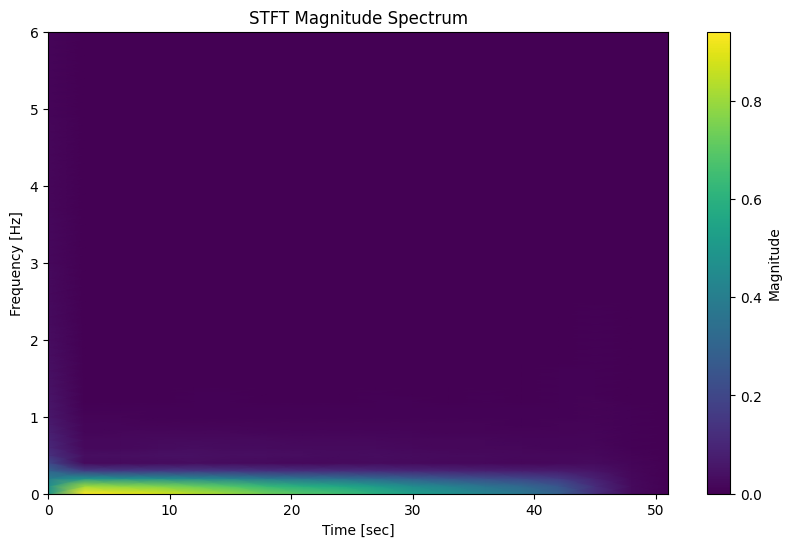

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Reshape data into 2D arrays for plotting
mag_matrix = mean_stft.pivot(index="Frequency", columns="Time", values="Magnitude").values
plt.pcolormesh(np.array(mean_stft["Time"].unique()),
               np.array(mean_stft["Frequency"].unique()),
               mag_matrix, shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 6)
plt.xlabel('Time [sec]')
plt.title('STFT Magnitude Spectrum')
plt.show()

## 2) Compute the STFT for the sway of one participant: Computation after feature extraction

Here, we are going to extract the feature of the sway of each participant by substracting a filtered trajectory to the raw trajectory.
We are then going to project this feature on the referential of the filtered trajectory to deal with trajectory changes.
Finally, we will boost the signal using a simple coefficient to increase visibility.

In [14]:
from scipy.ndimage import uniform_filter1d

## Smooth out swaying usin a gausian filtering of velocity
window_size = int(TrajectoryData_FT.frame_rate/2)


# Function to apply moving average filter to a group
def apply_moving_average_filter(group):
    group["x_filtered"] = uniform_filter1d(group[X_COL], size=window_size,mode = "nearest")
    group["y_filtered"] = uniform_filter1d(group[Y_COL], size=window_size,mode = "nearest")
    return group

# Apply the filter to each group
trajectory_data = TrajectoryData_FT.data.groupby("id").apply(apply_moving_average_filter, include_groups=True).droplevel(0)

## Remove the limit filtered data
# Compute the min and max frame for each id
min_frame = trajectory_data.groupby("id")["frame"].transform("min")
max_frame = trajectory_data.groupby("id")["frame"].transform("max")

# Filter out the first and last N frames for each id
trajectory_data = trajectory_data[
    ~((trajectory_data["frame"] <= min_frame + (window_size - 1)) | 
      (trajectory_data["frame"] >= max_frame - (window_size - 1)))
]

/var/folders/g6/y_cs15wx5b564jn2bfw70j1c0000gn/T/ipykernel_10944/966990327.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trajectory_data = TrajectoryData_FT.data.groupby("id").apply(apply_moving_average_filter, include_groups=True).droplevel(0)


### Compute fluctuation vector by substracting the filtered trajectory 

In [15]:
# Compute fluctuation vector
trajectory_data["x_fluctuation"] = trajectory_data[X_COL] - trajectory_data["x_filtered"]
trajectory_data["y_fluctuation"] = trajectory_data[Y_COL] - trajectory_data["y_filtered"]

### project fluctuation on the manifold orthogonal to filtered trajectory

In [16]:
# Compute directional vector (difference between consecutive filtered points)
opperation_df= trajectory_data.copy()
opperation_df["dx_filtered"] = opperation_df.groupby("id")["x_filtered"].diff()
opperation_df["dy_filtered"] = opperation_df.groupby("id")["y_filtered"].diff()

# Fill NaN values (first row per "id" where diff() results in NaN)
opperation_df["dx_filtered"] = opperation_df.groupby("id")["dx_filtered"].fillna(method="bfill")
opperation_df["dy_filtered"] = opperation_df.groupby("id")["dy_filtered"].fillna(method="bfill")


# Normalize the directional vector (to get unit vector)
norm = np.sqrt(opperation_df["dx_filtered"]**2 + opperation_df["dy_filtered"]**2)
opperation_df["dx_filtered_unit"] = opperation_df["dx_filtered"] / norm
opperation_df["dy_filtered_unit"] = opperation_df["dy_filtered"] / norm

# Compute the orthogonal unit vector
opperation_df["dx_ortho"] = -opperation_df["dy_filtered_unit"]
opperation_df["dy_ortho"] = opperation_df["dx_filtered_unit"]

# Compute scalar product (dot product) with the orthogonal vector
trajectory_data["projected_fluctuation"] = (opperation_df["x_fluctuation"] * opperation_df["dx_ortho"] + opperation_df["y_fluctuation"] * opperation_df["dy_ortho"])



/var/folders/g6/y_cs15wx5b564jn2bfw70j1c0000gn/T/ipykernel_10944/337149765.py:7: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  opperation_df["dx_filtered"] = opperation_df.groupby("id")["dx_filtered"].fillna(method="bfill")
/var/folders/g6/y_cs15wx5b564jn2bfw70j1c0000gn/T/ipykernel_10944/337149765.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  opperation_df["dx_filtered"] = opperation_df.groupby("id")["dx_filtered"].fillna(method="bfill")
/var/folders/g6/y_cs15wx5b564jn2bfw70j1c0000gn/T/ipykernel_10944/337149765.py:8: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single

### Computation of the STFT

In [17]:
# Group the data by 'id' and apply the STFT function

stft_results = (
                trajectory_data.groupby("id")["projected_fluctuation"]
                .apply(lambda x: compute_STFT(x, 
                                  TrajectoryData_FT.frame_rate, 
                                  segments_length=5*TrajectoryData_FT.frame_rate, 
                                  overlap_length=3*TrajectoryData_FT.frame_rate,
                                  zeros_padded=20*TrajectoryData_FT.frame_rate
                                )
                                  
                        )
            )

# Reset index to  makes "id" a column instead of an index.
stft_results = stft_results.reset_index()

### Normalisation of the results

In [18]:
# Find the maximum Time value and its associated id
max_time_row = stft_results.loc[stft_results["Time"].idxmax()]
max_time = max_time_row["Time"]
max_time_id = max_time_row["id"]


# print(f"Max Time: {max_time}, Associated ID: {max_time_id}")

# Determine time resolution of the series for the ID with max Time
max_time_series = stft_results[stft_results["id"] == max_time_id]
time_resolution = np.diff(np.sort(max_time_series["Time"].unique())).min()

# print(f"Time resolution for ID {max_time_id}: {time_resolution}")

In [19]:
# Resample all time series and interpolate missing values
from scipy.interpolate import interp1d

# Create a new uniform time grid for resampling
new_time_grid = np.arange(0, max_time + time_resolution, time_resolution)

# loop over all IDs and frequencies
resampled_data = []
for id_val, group in stft_results.groupby("id"):
    frequencies = group["Frequency"].unique()  # Get unique frequencies

    for freq in frequencies:
        freq_group = group[group["Frequency"] == freq]

        old_time = freq_group["Time"].values
        magnitude = freq_group["Magnitude"].values
        phase = freq_group["Phase"].values

        # Interpolation functions
        interp_magnitude = interp1d(old_time, magnitude, kind="linear", fill_value="extrapolate")
        interp_phase = interp1d(old_time, phase, kind="linear", fill_value="extrapolate")

        # Compute new values at the uniform time grid
        new_magnitude = interp_magnitude(new_time_grid)
        new_phase = interp_phase(new_time_grid)

        # Pad missing values (last valid value)
        last_magnitude = 0 # magnitude[-1]
        last_phase = 0 # phase[-1]

        new_magnitude[len(old_time):] = last_magnitude
        new_phase[len(old_time):] = last_phase

        # Store resampled data
        for t, mag, ph in zip(new_time_grid, new_magnitude, new_phase):
            resampled_data.append([id_val, freq, t, mag, ph])

# Create a new DataFrame
STFT_results__resampled = pd.DataFrame(resampled_data, columns=["id", "Frequency", "Time", "Magnitude", "Phase"])



### Compute the Mean STFT across all participants

In [20]:

# Compute mean Magnitude and Phase for each (Frequency, Time) pair
mean_stft = (
    STFT_results__resampled.groupby(["Frequency", "Time"], as_index=False)
    .mean()
)

## Plot the STFT Magnitude Spectrum 

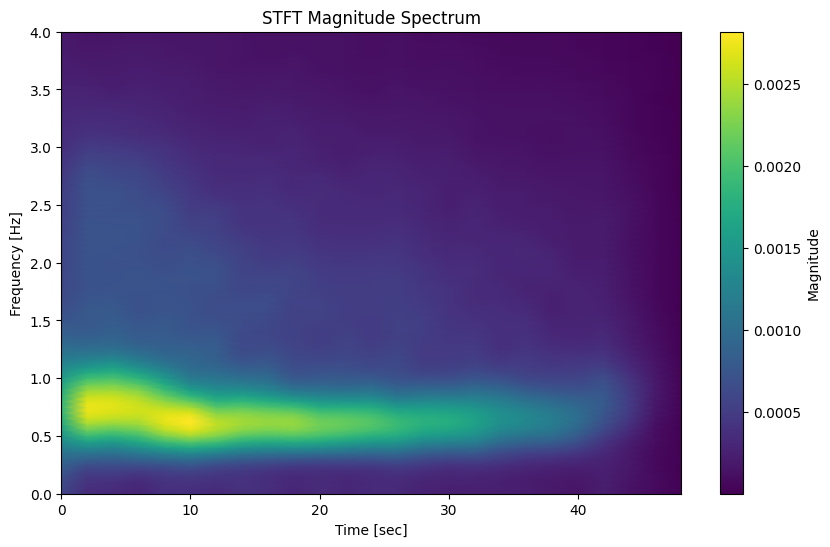

In [21]:
import numpy as np

# Create a new figure
plt.figure(figsize=(10, 6))

# Reshape data into 2D arrays for plotting
mag_matrix = mean_stft.pivot(index="Frequency", columns="Time", values="Magnitude").values
plt.pcolormesh(np.array(mean_stft["Time"].unique()),
               np.array(mean_stft["Frequency"].unique()),
               mag_matrix, shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 4)
plt.xlabel('Time [sec]')
plt.title('STFT Magnitude Spectrum')
plt.show()

# Welch Spectral Distribution

## 1) Distribution for a single individual

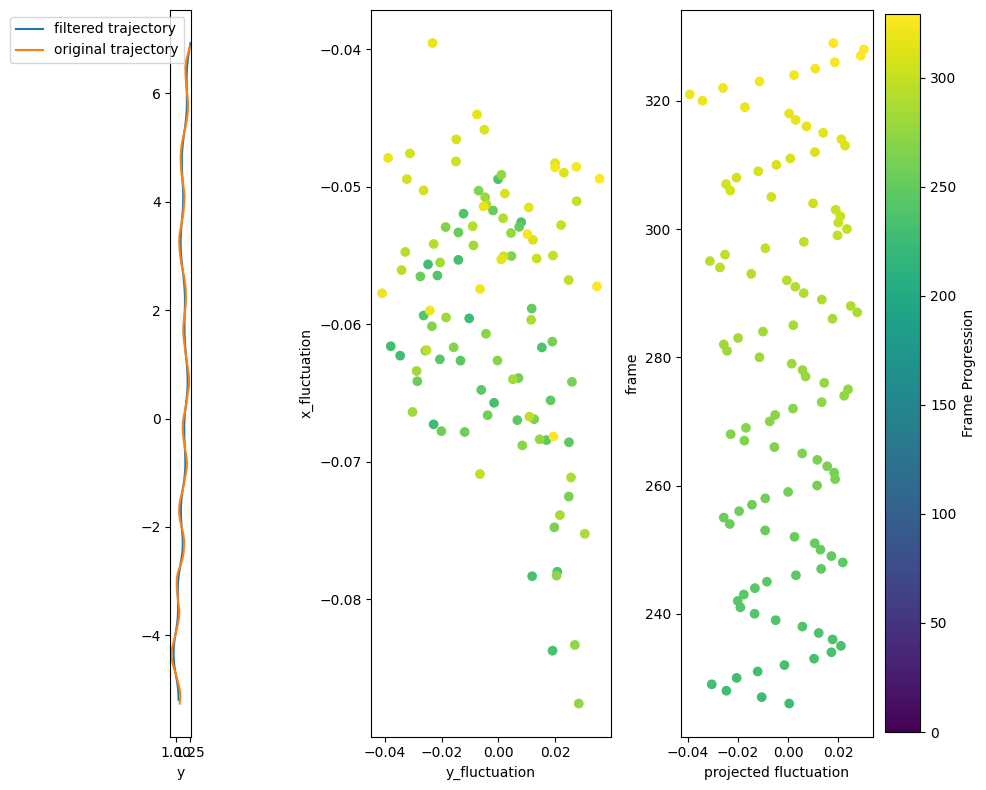

In [22]:
# Create a figure of a single trajectory and the extracted sway feature
fig, axs = plt.subplots(1, 3, figsize=(10, 8))

single_tajectory_data=trajectory_data[trajectory_data["id"]==1]


# Plot x_filtered
axs[0].plot(single_tajectory_data["x_filtered"], single_tajectory_data["y_filtered"],label="filtered trajectory")
axs[0].plot(single_tajectory_data["x"], single_tajectory_data["y"],label="original trajectory")
axs[0].set_xlabel("x")
axs[0].set_xlabel("y")
axs[0].legend()
axs[0].set_aspect("equal")

# Plot x_fluctuation
# Create a color map
cmap = plt.get_cmap("viridis")
# Map the frame values to RGB values
colors = cmap(np.array(single_tajectory_data["frame"]) / single_tajectory_data["frame"].max())
# Create a line plot
axs[1].scatter(single_tajectory_data["x_fluctuation"], single_tajectory_data["y_fluctuation"], color=colors)
axs[1].set_xlabel("y_fluctuation")
axs[1].set_ylabel("x_fluctuation")



# Plot norm_fluctuation
axs[2].scatter(single_tajectory_data["projected_fluctuation"], single_tajectory_data["frame"], color=colors)
axs[2].set_xlabel("projected fluctuation")
axs[2].set_ylabel("frame")


# Add a colorbar for frame values
import matplotlib.colors as mcolors
import matplotlib.cm as cm
norm = mcolors.Normalize(vmin=single_tajectory_data["frame"].max(), vmax=0)
cmap = plt.get_cmap("viridis")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=axs[2])
cbar.set_label("Frame Progression")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
# Computation of Welch Spectral Distribution
from pedpy import compute_welch_spectral_distribution
welch_distribution_result=compute_welch_spectral_distribution(single_tajectory_data["projected_fluctuation"],
                                                                TrajectoryData_FT.frame_rate,
                                                                segments_length=5*TrajectoryData_FT.frame_rate, 
                                                                overlap_length=4*TrajectoryData_FT.frame_rate,
                                                                zeros_padded=50*TrajectoryData_FT.frame_rate)


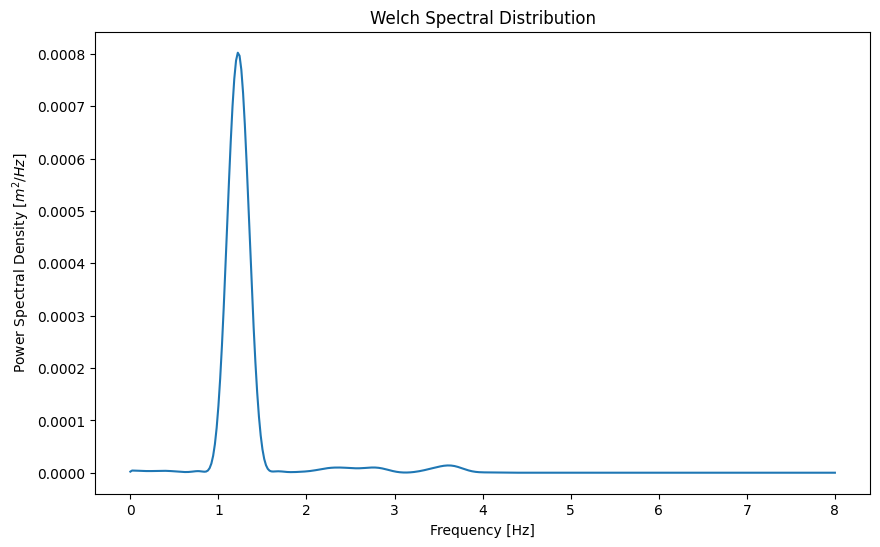

In [34]:
# Plot the Welch Spectral Distribution
plt.figure(figsize=(10, 6))
plt.plot(welch_distribution_result["Frequency"], welch_distribution_result["Power"])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density $[m^2/Hz]$")
plt.title("Welch Spectral Distribution") 
plt.show()

## 2) Distribution for all participants

In [35]:
# Claculation of the Welch Spectral Distribution for all participants
welch_results = (
                trajectory_data.groupby("id")["projected_fluctuation"]
                .apply(lambda x: compute_welch_spectral_distribution(x, 
                                  TrajectoryData_FT.frame_rate, 
                                  segments_length=TrajectoryData_FT.frame_rate*5, 
                                  overlap_length=TrajectoryData_FT.frame_rate*2,
                                  zeros_padded=TrajectoryData_FT.frame_rate*50
                                )
                                  
                        )
            )

# Reset index to  makes "id" a column instead of an index.
welch_results = welch_results.reset_index()

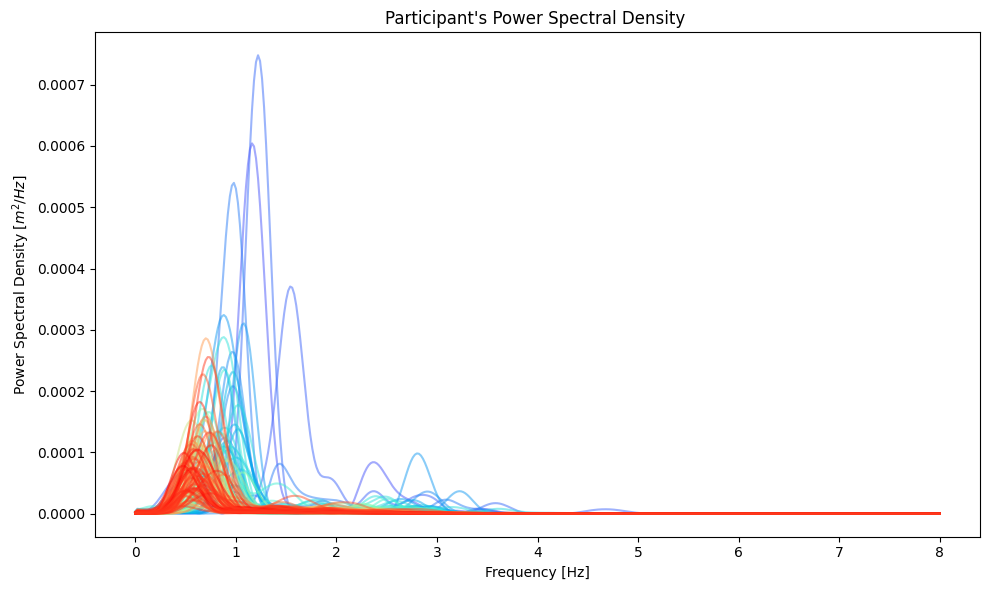

In [36]:
# Plot Welch Spectral Distribution

# First calculate the lengths for each ID
lengths = trajectory_data.groupby("id")["projected_fluctuation"].size()

# Normalize lengths to use as colormap values
norm_lengths = (lengths ) / (lengths.max())

# Create the plot
plt.figure(figsize=(10, 6))
colormap = plt.cm.rainbow

for id in welch_results["id"].unique():
    mask = welch_results["id"] == id
    color = colormap(norm_lengths[id])  # Get color based on normalized length
    plt.plot(welch_results[mask]["Frequency"], 
             welch_results[mask]["Power"], 
             color=color,
             alpha=0.5,
             )

plt.title("Participant's Power Spectral Density ")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density $[m^2/Hz]$")
plt.tight_layout()
plt.show()

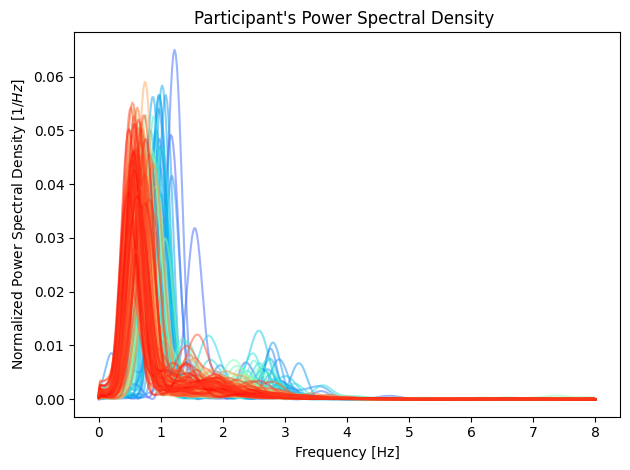

In [37]:
# Plot Nornalized Welch Spectral Distribution 

for id in welch_results["id"].unique():
    mask = welch_results["id"] == id
    color = colormap(norm_lengths[id])  # Get color based on normalized length
    plt.plot(welch_results[mask]["Frequency"], 
             welch_results[mask]["Power"]/welch_results[mask]["Power"].sum(), # Normalize each PSD by the total power. This way we have relative distribution of power over frequencies, rather than absolute values, allowing direct comparison.
             color=color,
             alpha=0.5,
             )

plt.title("Participant's Power Spectral Density ")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized Power Spectral Density $[1/Hz]$")
plt.tight_layout()
plt.show()

## Comparing Sway Frequency and Walking Speed 